# Model Definition and Evaluation
## Table of Contents
1. [Setup](#setup)
2. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Hyperparameter Tuning](#hyperparameter-tuning)
4. [Implementation](#implementation)
5. [Evaluation Metrics](#evaluation-metrics)
6. [Comparative Analysis](#comparative-analysis)


## Setup
### Imports

In [2]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os, json, hashlib

from datetime import datetime
from sklearn.preprocessing import StandardScaler
from huggingface_hub import login, list_repo_files, hf_hub_download, upload_file
from tensorflow.keras import layers, models
from sklearn.model_selection import ParameterGrid

### Configuration

In [ ]:
REPO_ID = "mttfst/Paulette_Cloud_Tracks"
token = "hf_XXX"

USER = "JS"

WINDOW_MINUTES =  45 #Minuten
CUTOFF_STEPS = 5
WINDOW_STEPS  = WINDOW_MINUTES * 2        # 30 min × 60 s / 30 s = 60 Steps
N_FEATURES    = 24        # 8 Skalare + 12 TS-Features

BATCH_SIZE = 32
EPOCHS = 40
LR = 1e-3
MODEL_TYPE = "GRU"    # "SimpleRNN" | "LSTM" | "GRU"
LOSS = "MSE"
UNITS1 = 64
UNITS2 = 32

In [4]:
# =========================================
# Login HuggingFace
# =========================================
login(token)

### Logging

In [5]:
# Du kannst hier ein separates Repo für Logs/Configs nutzen (empfohlen),
# oder du lässt es auf dem Dataset-Repo laufen.
CONFIG_REPO_ID = REPO_ID  # z.B. "thorsten789/hurricane_cloud_runs"

def make_run_id(prefix: str, config: dict) -> str:
    ts = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    cfg_str = json.dumps(config, sort_keys=True)
    h = hashlib.sha1(cfg_str.encode("utf-8")).hexdigest()[:10]
    return f"{prefix}_{ts}_{h}"

def save_json_local(path: str, data: dict) -> str:
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=2, ensure_ascii=False)
    return path

def upload_json_hf(local_path: str, run_id: str, name: str, base_dir: str = "runs", user= USER):
    """Lädt JSON als {base_dir}/{user}/{run_id}/{name}.json in CONFIG_REPO_ID hoch."""
    try:
        path_in_repo = f"{base_dir}/{user}/{run_id}/{name}.json"
        upload_file(
            path_or_fileobj=local_path,
            path_in_repo=path_in_repo,
            repo_id=CONFIG_REPO_ID,
            repo_type="dataset",
            commit_message=f"Add {name}.json for {run_id}",
        )
        print(f"[HF] uploaded: {path_in_repo}")
    except Exception as e:
        print(f"[HF] upload skipped/failed ({name}): {e}")

# --- zentrale Run-Config (die ID basiert auf config -> sinnvoller Run-Name)
RUN_CONFIG = {
    "model": MODEL_TYPE,
    "window_minutes": WINDOW_MINUTES,
    "optimizer": "adam",
    "units1": UNITS1,
    "units2": UNITS2,
    "lr": LR,
    "batch_size": BATCH_SIZE,
    "epochs": EPOCHS,
    "cutoff_steps": CUTOFF_STEPS,
    "loss": LOSS,
}

RUN_ID = make_run_id("simple_rnn", RUN_CONFIG)
print("RUN_ID:", RUN_ID)

# Setup sofort speichern (damit du schon am Anfang einen Run hast)
setup = {
    "run_id": RUN_ID,
    "config": RUN_CONFIG,
    "data": {"repo_id": REPO_ID},
    "meta": {"notebook": "3_Model/model_definition_evaluation_JS.ipynb"},
}

# +++ Logging: Save Setup +++
local_setup = save_json_local(f"runs_local/{RUN_ID}/setup.json", setup)
upload_json_hf(local_setup, RUN_ID, "setup")

class AutoSaveTrain(tf.keras.callbacks.Callback):
    """Speichert train.json am Ende von model.fit (History + best_val_loss)."""
    def __init__(self, run_id: str):
        super().__init__()
        self.run_id = run_id

    def on_train_end(self, logs=None):
        hist = getattr(self.model, "history", None)
        history_dict = hist.history if hist is not None else {}

        train_data = {
            "run_id": self.run_id,
            "history": history_dict,
            "summary": {
                "best_val_loss": float(min(history_dict["val_loss"])) if "val_loss" in history_dict else None,
                "final_train_loss": float(history_dict["loss"][-1]) if "loss" in history_dict and len(history_dict["loss"]) else None,
            },
        }
        local_train = save_json_local(f"runs_local/{self.run_id}/train.json", train_data)
        upload_json_hf(local_train, self.run_id, "train")


RUN_ID: simple_rnn_2026-02-24_10-37-51_96fdfa7e1f


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


[HF] upload skipped/failed (setup): The read operation timed out


### Load Data from HuggingFace

TRACK LENGTH FILE:

Diese CSV enthält Metadaten über alle Wolken:
- filename: Dateiname des Tracks
- track_len: Anzahl Zeitschritte (Lebensdauer)

WARUM WICHTIG?
- Wir trainieren nur auf Wolken mit >= 120 Zeitschritten
- Grund: Kurze Wolken (<60 Minuten) sind zu variabel/chaotisch
- Längere Wolken zeigen klare Lebenszyklen

DATENQUELLE:
Diese Datei wurde vorberechnet aus allen Tracks.
Spart Zeit beim Training-Setup.

In [6]:
tracks_120 = None

# Wenn lokal nicht da: von Hugging Face Dataset-Repo herunterladen
if tracks_120 is None:
    from huggingface_hub import hf_hub_download

    filename_in_repo = "track_len/track_len_exp_1.1.csv"

    print(f"⬇️  Downloading from HF: {REPO_ID}/{filename_in_repo}")
    local_file = hf_hub_download(
        repo_id=REPO_ID,
        repo_type="dataset",
        filename=filename_in_repo,
    )

    print(f"✅ Loading track_len from HF-cached file: {local_file}")
    tracks_120 = pd.read_csv(local_file)

print("tracks_120 shape:", tracks_120.shape)
tracks_120.head()

# =========================================
# Dataset-Split
# =========================================
files = list_repo_files(REPO_ID, repo_type="dataset")
csv_files = [f for f in files if f.startswith("exp_1.1/") and f.endswith(".csv")]

tracks_120 = tracks_120[tracks_120.track_len >= 120]
print("Total CSV tracks with at least 120 timesteps:", len(tracks_120))

tracks_120 = tracks_120.filename.to_list()

csv_files = [
    f for f in csv_files
    if f.split("/")[1] in tracks_120
]

random.seed(42)
random.shuffle(csv_files)

n = len(csv_files)
train_files = csv_files[: int(0.7 * n)]
val_files   = csv_files[int(0.7 * n): int(0.85 * n)]
test_files  = csv_files[int(0.85 * n):]

#train_files= csv_files[:150]
#val_files= csv_files[150:175]
#test_files= csv_files[175:200]

print(f"Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")

⬇️  Downloading from HF: mttfst/Paulette_Cloud_Tracks/track_len/track_len_exp_1.1.csv


track_len_exp_1.1.csv:   0%|          | 0.00/173k [00:00<?, ?B/s]

✅ Loading track_len from HF-cached file: /root/.cache/huggingface/hub/datasets--mttfst--Paulette_Cloud_Tracks/snapshots/2fc55445140ae634609931938f0cfa469008b113/track_len/track_len_exp_1.1.csv
tracks_120 shape: (9227, 2)
Total CSV tracks with at least 120 timesteps: 1115
Train: 780, Val: 167, Test: 168


## Model Selection

[Discuss the type(s) of models you consider for this task, and justify the selection.]



## Feature Engineering

[Describe any additional feature engineering you've performed beyond what was done for the baseline model.]


In [7]:
PROFILE_PREFIXES = ["qr_", "qc_", "qi_", "qs_", "qg_", "qv_", "roh_", "w_"]

SCALAR_FEATURES = [
    "cape_ml_L00", "cin_ml_L00",
    "lwp_L00",
    "iwp_L00", "rain_gsp_rate_L00",
    "tqc_L00", "tqi_L00", "area_m2"
]

In [8]:
def compute_remaining_lifetime(df, timestep_seconds=30):
    n = len(df)
    remaining_seconds = [(n - i - 1) * timestep_seconds for i in range(n)]
    remaining_minutes = [s / 60 for s in remaining_seconds]
    return remaining_minutes

#def compute_future_rain(df, timestep_minutes=5):
#    rain = df["rain_gsp_rate_L00"].values
#    dt = timestep_minutes * 60  # Sekunden

#    future_rain = []
#    for i in range(len(rain)):
#        future_rain.append(rain[i:].sum() * dt)

#    return future_rain

In [9]:
def extract_profile(df, prefix, n_levels=50):
    """
    Extrahiert ein vertikales Profil mit exakt n_levels.
    Fehlende Level werden mit 0 aufgefüllt.
    """
    data = np.zeros((len(df), n_levels), dtype="float32")
    for i in range(n_levels):
        col = f"{prefix}L{i:02d}"
        if col in df.columns:
            data[:, i] = df[col].values
    return data

In [10]:
def extract_ts_features_from_profiles(profiles):
    """
    profiles: (T, Z, F) mit F = len(PROFILE_PREFIXES)
    Level 50=unten → Level 0=oben
    """

    # --- hard-coded z-levels (physikalische Höhen) ---
    z = np.array([
        3.136780e+04, 2.736595e+04, 2.492369e+04, 2.294698e+04, 2.125334e+04,
        1.975951e+04, 1.841803e+04, 1.719845e+04, 1.607970e+04, 1.504641e+04,
        1.408694e+04, 1.319217e+04, 1.235481e+04, 1.156892e+04, 1.082956e+04,
        1.013258e+04, 9.474455e+03, 8.852140e+03, 8.263009e+03, 7.704765e+03,
        7.175387e+03, 6.673090e+03, 6.196285e+03, 5.743555e+03, 5.313629e+03,
        4.905366e+03, 4.517735e+03, 4.149806e+03, 3.800737e+03, 3.469765e+03,
        3.156199e+03, 2.859414e+03, 2.578843e+03, 2.313976e+03, 2.064356e+03,
        1.829575e+03, 1.609273e+03, 1.403137e+03, 1.210904e+03, 1.032357e+03,
        8.673333e+02, 7.157275e+02, 5.774996e+02, 4.526887e+02, 3.414336e+02,
        2.440081e+02, 1.608839e+02, 9.285786e+01, 4.137239e+01, 1.000000e+01
    ], dtype="float32")
    
    idx = {name: i for i, name in enumerate(PROFILE_PREFIXES)}
    
    T, Z = profiles.shape[:2]
    if Z != z.shape[0]:
        raise ValueError(f"Z={Z} passt nicht zu z_levels={z.shape[0]}")
    
    levels = np.arange(Z-1, -1, -1, dtype="float32")  # 49...0 (unten→oben)
    
    ts_features = []
    
    for t in range(T):
        # Profile extrahieren
        qc_t = profiles[t, :, idx["qc_"]]  # (50,)
        qi_t = profiles[t, :, idx["qi_"]]
        qr_t = profiles[t, :, idx["qr_"]]
        w_t  = profiles[t, :, idx["w_"]]
        
        # Wolkenmaske (qc+qi > Schwellwert)
        cloud_mask = (qc_t + qi_t) > 0
        
        if not np.any(cloud_mask):
            ts_features.append(np.zeros(12, dtype="float32"))
            continue
        
        # 1. GEOMETRIE
        cloud_heights = z[cloud_mask]       # physikalische Höhen der Wolkenlevel [m]
        cloud_base    = cloud_heights.min() # unterste Wolkenhöhe (kleinste z-Koordinate)
        cloud_top     = cloud_heights.max() # oberste Wolkenhöhe (größte z-Koordinate)
        cloud_thickness = cloud_top - cloud_base
        # Hinweis: z[0] = 31367m (oben), z[49] = 10m (unten)
        
        # 2. MASSE
        cloud_mass = np.sum(qc_t + qi_t)
        rain_mass  = np.sum(qr_t)
        
        # 3. DYNAMIK (nur in Wolke)
        w_in_cloud = w_t[cloud_mask]
        mean_w = np.mean(w_in_cloud)
        max_w  = np.max(w_in_cloud)
        
        # 4. HÖHENINFO (Level-Indizes 0-49)
        height_max_qc = float(z[int(np.argmax(qc_t))])
        height_max_w  = float(z[int(np.argmax(w_t))])
        
        # 5. EXTRA (wie in deinem Code)
        weights = qc_t + qi_t
        center_of_mass = float(np.sum(z * weights) / (cloud_mass + 1e-12))
        max_qc = np.max(qc_t)
        std_w_cloud = np.std(w_in_cloud)
        
        ts_features.append([
            cloud_base, cloud_top, cloud_thickness,      # Geometrie (3)
            cloud_mass, rain_mass,                       # Masse (2)  
            mean_w, max_w,                               # Dynamik (2)
            height_max_qc, height_max_w,                 # Höheninfo (2)
            center_of_mass, max_qc, std_w_cloud          # Extra (3)
        ])
    
    return np.array(ts_features, dtype="float32")


In [18]:
def compute_temporal_derivatives(df, window=3):
    """
    Berechnet Änderungsraten über die letzten `window` Zeitschritte.
    
    Neue Features:
    - d_area_dt      : Wie schnell wächst/schrumpft die Wolke?
    - d_lwp_dt       : Steigt Flüssigwasser (Entwicklung) oder fällt es (Dissipation)?
    - d_rain_rate_dt : Beschleunigt/verlangsamt sich der Regen?
    - d_cape_dt      : Wird die Atmosphäre instabiler oder stabiler?
    
    Begründung: RUL hängt stark davon ab ob Wolke wächst oder schrumpft!
    Nutzt backward diff normalerweise, forward diff am Anfang.
    """
    features = {}
    
    for col in ['area_m2', 'lwp_L00', 'rain_gsp_rate_L00', 'cape_ml_L00']:
        if col in df.columns:
            # Backward diff (normal)
            diff_back = df[col].diff(periods=1)
            
            # Forward diff für erste Zeilen
            diff_forward = df[col].diff(periods=-1).shift(1)
            
            # Kombiniere: Nutze forward nur wo backward NaN ist
            diff_combined = diff_back.fillna(diff_forward)
            
            # Smoothing
            features[f'd_{col}_dt'] = diff_combined.rolling(
                window=window, 
                min_periods=1
            ).mean().fillna(0.0)
    
    return pd.DataFrame(features)

In [19]:
def preprocess_cloud(df):
    df = df.sort_values("time")

    # Target
    y_lifetime = compute_remaining_lifetime(df)

    # Profile (T, Z, F)
    profile_features = []
    for prefix in PROFILE_PREFIXES:
        prof = extract_profile(df, prefix, n_levels=50)
        profile_features.append(prof)
    
    profiles = np.stack(profile_features, axis=-1)

    # cin and cape only every 5min interpolate the rest
    df['cin_ml_L00'] = df['cin_ml_L00'].interpolate(method='linear').bfill()
    df['cape_ml_L00'] = df['cape_ml_L00'].interpolate(method='linear').bfill()
    
    # Scalars
    scalars = df[SCALAR_FEATURES].values.astype("float32")
    
    # neue TS-Features
    ts_features = extract_ts_features_from_profiles(profiles)

    # Zeitliche Ableitungen
    temporal_df = compute_temporal_derivatives(df)

    # 3. ALLES ZUSAMMENFÜHREN
    # Alle DataFrames zu numpy
    temporal_arr = temporal_df.values.astype("float32")

    combined_scalars = np.concatenate([
        scalars,               # (T, 8)
        temporal_arr,          # (T, 4)
        #thermo_arr,            # (T, 3)
        #spatial_arr,           # (T, 3) [1 wenn lat/lon fehlt]
        #interaction_arr,       # (T, 3)
    ], axis=1)

    return {
        "ts_features": ts_features,      # (T, 12)
        "scalars": combined_scalars,              # (T, 8)
        "y": np.array(y_lifetime, dtype="float32")[:, None]
    }

In [20]:
def load_and_preprocess(files):
    samples = []
    for f in files:
        local_file = hf_hub_download(
            repo_id=REPO_ID,
            repo_type="dataset",
            filename=f,
        )
        df = pd.read_csv(local_file)
        
        if len(df) <= CUTOFF_STEPS:
            continue
        
        sample = preprocess_cloud(df)
        samples.append(sample)
    
    return samples

In [21]:
print("Loading data...")
train_samples = load_and_preprocess(train_files)
val_samples   = load_and_preprocess(val_files)
test_samples  = load_and_preprocess(test_files)

print(f"Loaded: {len(train_samples)} train, {len(val_samples)} val, {len(test_samples)} test")

Loading data...
Loaded: 780 train, 167 val, 168 test


In [22]:
def create_fixed_window_sequences(samples, 
                                   window_minutes=WINDOW_MINUTES,
                                   stride=1):
    """
    Erstellt Sliding-Window Sequenzen aus den Samples.
    
    Parameter:
    ----------
    samples      : Liste von preprocessierten Wolken-Dicts
    window_minutes: Fensterlänge in Minuten
    stride       : Schrittweite des Fensters in Zeitschritten (30-Sek.-Steps)
                   stride=1  → maximale Überlappung (viele, korrelierte Samples)
                   stride=30 → kein Overlap (1 Fenster pro 15 Minuten)
                   stride=WINDOW_STEPS → kein Overlap (non-overlapping windows)
    
    Returns:
    --------
    X : np.array, Shape (N, WINDOW_STEPS, n_features)
    y : np.array, Shape (N, 1)
    """
    
    # 30 Sek./Step → 30min = 60 Steps
    WINDOW_STEPS = int(window_minutes * 60 / 30)
    
    X, y = [], []
    skipped = 0

    for s in samples:
        combined = np.concatenate([s["scalars"], s["ts_features"]], axis=1)
        T = len(combined)
        
        # Wolke zu kurz für auch nur ein Fenster
        if T <= WINDOW_STEPS:
            skipped += 1
            continue
        
        # Sliding Window mit Stride
        for i in range(0, T - WINDOW_STEPS, stride):
            X.append(combined[i : i + WINDOW_STEPS])
            y.append(s["y"][i + WINDOW_STEPS])
    
    if skipped > 0:
        print(f"  ⚠️  {skipped} Wolken zu kurz für Window ({WINDOW_STEPS} Steps), übersprungen.")
    
    X = np.array(X, dtype="float32")
    y = np.array(y, dtype="float32")
    
    print(f"  Window: {WINDOW_STEPS} Steps ({window_minutes} min) | "
          f"Stride: {stride} Steps ({stride*30/60:.1f} min) | "
          f"→ {X.shape[0]} Sequenzen")
    
    return X, y

# Training: moderater Stride für mehr Daten, aber weniger Korrelation
X_train, y_train = create_fixed_window_sequences(train_samples, stride=12)

# Validation/Test: größerer Stride → unabhängigere Evaluation
X_val, y_val   = create_fixed_window_sequences(val_samples,   stride=12)
X_test, y_test = create_fixed_window_sequences(test_samples,  stride=60)

  Window: 90 Steps (45 min) | Stride: 12 Steps (6.0 min) | → 8537 Sequenzen
  Window: 90 Steps (45 min) | Stride: 12 Steps (6.0 min) | → 1802 Sequenzen
  Window: 90 Steps (45 min) | Stride: 60 Steps (30.0 min) | → 375 Sequenzen


In [23]:
sample = train_samples[0]
ts_features = sample["ts_features"]

print("cloud_base  > cloud_top?", np.all(ts_features[:,0] >= ts_features[:,1]))
print("thickness > 0?", np.all(ts_features[:,2] > 0))
print("Sample values:\n", ts_features[:3, :5])  # Erste 5 Features

cloud_base  > cloud_top? False
thickness > 0? True
Sample values:
 [[3.4143359e+02 2.1253340e+04 2.0911906e+04 8.6598527e-03 1.0412185e-02]
 [3.4143359e+02 2.1253340e+04 2.0911906e+04 9.4145974e-03 1.1317367e-02]
 [3.4143359e+02 2.1253340e+04 2.0911906e+04 1.0146300e-02 1.2264996e-02]]


In [24]:
sample = train_samples[5]

scalars = sample["scalars"]          # (T, 8)
ts      = sample["ts_features"]      # (T, 12)

# Zu (T, 20) zusammenfügen
combined = np.concatenate([scalars, ts], axis=1)

cols = [
    "cape_ml_L00", "cin_ml_L00",
    "lwp_L00",
    "iwp_L00", "rain_gsp_rate_L00",
    "tqc_L00", "tqi_L00", "area_m2",
    "d_area_dt",  "d_lwp_dt",       
    "d_rain_rate_dt", "d_cape_dt",
    "cloud_base", "cloud_top", "cloud_thickness",
    "cloud_mass", "rain_mass",
    "mean_w", "max_w",
    "height_max_qc", "height_max_w",
    "center_of_mass", "max_qc", "std_w_in_cloud"
]

ts_df = pd.DataFrame(combined, columns=cols)
ts_df.head()

,cape_ml_L00,cin_ml_L00,lwp_L00,iwp_L00,rain_gsp_rate_L00,tqc_L00,tqi_L00,area_m2,d_area_dt,d_lwp_dt,...,cloud_thickness,cloud_mass,rain_mass,mean_w,max_w,height_max_qc,height_max_w,center_of_mass,max_qc,std_w_in_cloud
0,576.275513,0.651910,3.438309,0.027893,0.000058,2.040051,0.026654,39200000.0,0.0,0.000000,...,20675.839844,0.009000,0.008883,0.433838,1.360267,3469.764893,1829.574951,2343.608398,0.001148,0.496726
1,576.275513,0.651910,3.814658,0.028027,0.002829,2.170840,0.026790,39200000.0,0.0,0.376349,...,20675.839844,0.009522,0.010446,0.483662,1.522002,3469.764893,1829.574951,2370.172852,0.001329,0.555175
2,582.054993,0.738171,4.220475,0.028167,0.002829,2.327938,0.026932,39200000.0,0.0,0.391083,...,20675.839844,0.010117,0.012021,0.522380,1.673126,3469.764893,1829.574951,2427.403809,0.001471,0.603822
3,587.834473,0.824432,4.600415,0.028311,0.002829,2.466708,0.027077,39200000.0,0.0,0.387369,...,20675.839844,0.010612,0.013542,0.550875,1.809961,3469.764893,2064.355957,2499.750000,0.001249,0.649626
4,593.613892,0.910693,4.912405,0.028458,0.002829,2.555361,0.027225,39200000.0,0.0,0.365915,...,20537.613281,0.010920,0.014943,0.582250,1.940556,3469.764893,2064.355957,2543.482178,0.001310,0.703072


### Normalisierung

In [25]:
print("Start Normalization")

scaler = StandardScaler()
X_train_flat = X_train.reshape(-1, X_train.shape[-1])  # (4500, 12)
X_train_scaled = scaler.fit_transform(X_train_flat).reshape(X_train.shape)

X_val_flat = X_val.reshape(-1, X_val.shape[-1])
X_val_scaled = scaler.transform(X_val_flat).reshape(X_val.shape)

X_test_flat = X_test.reshape(-1, X_test.shape[-1])
X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape)

print("TS alle Splits skaliert")

print(f"Final shapes:")
print(f"  Train: TS={X_train_scaled.shape}")
print(f"  Val:   TS={X_val_scaled.shape}")
print(f"  Test:  TS={X_test_scaled.shape}")


Start Normalization
TS alle Splits skaliert
Final shapes:
  Train: TS=(8537, 90, 24)
  Val:   TS=(1802, 90, 24)
  Test:  TS=(375, 90, 24)


In [26]:
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled   = y_scaler.transform(y_val)
y_test_scaled  = y_scaler.transform(y_test)

print(f"Final shapes:")
print(f"  Train: TS={y_train_scaled.shape}")
print(f"  Val:   TS={y_val_scaled.shape}")
print(f"  Test:  TS={y_test_scaled.shape}")

Final shapes:
  Train: TS=(8537, 1)
  Val:   TS=(1802, 1)
  Test:  TS=(375, 1)


## Hyperparameter Tuning

[Discuss any hyperparameter tuning methods you've applied, such as Grid Search or Random Search, and the rationale behind them.]


In [27]:
def hyperparameter_search(
    X_train, y_train, X_val, y_val,
    model_builder_fn,
    param_grid,
    epochs=20,
    batch_size=32,
    patience=5,
    metric="val_loss",
    verbose=1,
    save_dir="hp_search_results"
):
    """
    Grid Search für Hyperparameter-Tuning mit Early Stopping.
    
    Parameter:
    ----------
    X_train, y_train : Training data (skaliert!)
    X_val, y_val     : Validation data (skaliert!)
    model_builder_fn : Funktion die Modell baut, z.B. build_lstm
                       Muss **kwargs akzeptieren
    param_grid       : Dict mit Listen von Werten, z.B.:
                       {
                         'units1': [32, 64, 128],
                         'units2': [16, 32],
                         'dropout': [0.2, 0.3],
                         'lr': [1e-3, 3e-4, 1e-4]
                       }
    epochs           : Max Epochs pro Konfiguration
    batch_size       : Batch Size
    patience         : Early Stopping Patience
    metric           : Metrik zur Bewertung ('val_loss' empfohlen)
    verbose          : 0=silent, 1=progress bar, 2=eine Zeile pro epoch
    save_dir         : Ordner für Ergebnisse
    
    Returns:
    --------
    results : Liste von Dicts mit allen Experimenten
    best_params : Dict mit besten Parametern
    best_score  : Beste Metrik-Wert
    """
    
    os.makedirs(save_dir, exist_ok=True)
    
    # Parameter-Kombinationen generieren
    grid = list(ParameterGrid(param_grid))
    print(f"🔍 Hyperparameter Search: {len(grid)} Konfigurationen")
    print(f"   Metric: {metric} | Patience: {patience} | Max Epochs: {epochs}\n")
    
    results = []
    best_score = float('inf')
    best_params = None
    
    for i, params in enumerate(grid):
        print(f"\n{'='*60}")
        print(f"[{i+1}/{len(grid)}] Testing: {params}")
        print(f"{'='*60}")
        
        # LR separat behandeln (nicht Teil von model_builder)
        lr = params.pop('lr', 1e-3)
        
        # Modell bauen
        try:
            model = model_builder_fn(**params)
        except Exception as e:
            print(f"⚠️  Fehler beim Modellbau: {e}")
            params['lr'] = lr  # LR zurück in params
            continue
        
        # Kompilieren
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0),
            loss='mse',
            metrics=['mae']
        )
        
        # Callbacks
        cb = [
            callbacks.EarlyStopping(
                monitor=metric,
                patience=patience,
                restore_best_weights=True,
                verbose=0
            ),
            callbacks.TerminateOnNaN(),
        ]
        
        # Training
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=cb,
            verbose=verbose
        )
        
        # Beste Metrik aus History
        metric_values = history.history.get(metric, [])
        if not metric_values:
            print(f"⚠️  Metrik '{metric}' nicht gefunden!")
            params['lr'] = lr
            continue
        
        score = min(metric_values)
        epoch_best = int(np.argmin(metric_values)) + 1
        
        # Speichern
        params['lr'] = lr  # LR zurück in params
        result = {
            'params': params.copy(),
            'score': float(score),
            'epoch_best': epoch_best,
            'history': {k: [float(v) for v in vals] for k, vals in history.history.items()}
        }
        results.append(result)
        
        print(f"✅ {metric}={score:.4f} @ Epoch {epoch_best}")
        
        # Bestes Modell tracken
        if score < best_score:
            best_score = score
            best_params = params.copy()
            print(f"   🏆 Neuer Bestwert!")
            
            # Best Model speichern
            model.save(f"{save_dir}/best_model.keras")
    
    # Ergebnisse sortieren
    results.sort(key=lambda x: x['score'])
    
    # JSON speichern
    with open(f"{save_dir}/hp_search_results.json", "w") as f:
        json.dump({
            'best_params': best_params,
            'best_score': float(best_score),
            'all_results': results
        }, f, indent=2)
    
    print(f"\n{'='*60}")
    print(f"🏆 BESTE KONFIGURATION")
    print(f"{'='*60}")
    print(f"Params: {best_params}")
    print(f"{metric}: {best_score:.4f}")
    print(f"\nGespeichert in: {save_dir}/")
    
    return results, best_params, best_score



In [28]:
param_grid = {
    'units1':  [32, 64, 128],
    'units2':  [16, 32, 64],
    'dropout': [0.2, 0.3, 0.4],
    'lr':      [1e-3, 3e-4, 1e-4]
}

results, best_params, _ = hyperparameter_search(
    X_train_scaled, y_train_scaled,
    X_val_scaled, y_val_scaled,
    model_builder_fn=build_lstm,
    param_grid=param_grid,
    epochs=30,
    patience=5
)



NameError: name 'build_lstm' is not defined

## Implementation

[Implement the final model(s) you've selected based on the above steps.]


In [29]:
def build_simple_rnn(window_steps=WINDOW_STEPS,
                     n_features=N_FEATURES,
                     units1=UNITS1, units2=UNITS2,
                     dropout=0.2):
    """
    Baseline: einfaches SimpleRNN.
    Schnell, aber schwach bei langen Abhängigkeiten.
    """
    inp = layers.Input(shape=(window_steps, n_features), name="input")

    x = layers.SimpleRNN(units1, return_sequences=True,
                         name="rnn_1")(inp)
    x = layers.Dropout(dropout)(x)
    x = layers.SimpleRNN(units2, return_sequences=False,
                         name="rnn_2")(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(16, activation="relu")(x)
    out = layers.Dense(1, name="rul_output")(x)

    return models.Model(inp, out, name="SimpleRNN_RUL")

In [30]:
def build_gru(window_steps=WINDOW_STEPS,
              n_features=N_FEATURES,
              units1=UNITS1, units2=UNITS2,
              dropout=0.2):
    """
    GRU: gute Balance zwischen LSTM-Qualität und SimpleRNN-Geschwindigkeit.
    Gute Alternative zu LSTM.
    """
    inp = layers.Input(shape=(window_steps, n_features), name="input")

    x = layers.GRU(units1, return_sequences=True, name="gru_1")(inp)
    x = layers.Dropout(dropout)(x)
    x = layers.GRU(units2, return_sequences=False, name="gru_2")(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(16, activation="relu")(x)
    out = layers.Dense(1, name="rul_output")(x)

    return models.Model(inp, out, name="GRU_RUL")

In [31]:
def build_lstm(window_steps=WINDOW_STEPS,
               n_features=N_FEATURES,
               units1=UNITS1, units2=UNITS2,
               dropout=0.2):
    """
    LSTM: besser bei langen zeitlichen Abhängigkeiten.
    Empfehlung für diesen Use Case.
    """
    inp = layers.Input(shape=(window_steps, n_features), name="input")

    x = layers.LSTM(units1, return_sequences=True, name="lstm_1")(inp)
    x = layers.Dropout(dropout)(x)
    x = layers.LSTM(units2, return_sequences=False, name="lstm_2")(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(16, activation="relu")(x)
    out = layers.Dense(1, name="rul_output")(x)

    return models.Model(inp, out, name="LSTM_RUL")

In [32]:
def get_model(model_type=MODEL_TYPE):
    builders = {
        "SimpleRNN":  build_simple_rnn,
        "LSTM":       build_lstm,
        "GRU":        build_gru,
    }
    assert model_type in builders, f"Unbekanntes Modell: {model_type}"
    return builders[model_type]()

In [33]:
def hybrid_mse_cubic_loss(y_true, y_pred, alpha=0.7):
    err = y_true - y_pred
    mse = tf.reduce_mean(tf.square(err), axis=-1)
    mce = tf.reduce_mean(tf.pow(tf.abs(err), 3), axis=-1)
    return alpha * mse + (1.0 - alpha) * mce

In [34]:
model = get_model(MODEL_TYPE)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR, clipnorm=1.0),
    #loss="mse",
    loss =hybrid_mse_cubic_loss,
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(name="mae"),
        tf.keras.metrics.RootMeanSquaredError(name="rmse"),
    ]
)

model.summary()

Model: "GRU_RUL"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 90, 24)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 90, 64)         │        17,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rul_output (Dense)              │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,233 (106.38 KB)

 Trainable params: 27,233 (106.38 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
callbacks = [
    # Early Stopping
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    # Learning Rate Reduction
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    # NaN Detection
    tf.keras.callbacks.TerminateOnNaN(),
    # Auto-save train history (config logging)
    # +++ Logging: Add training log as callback function +++
    AutoSaveTrain(RUN_ID)
]

In [36]:
print(f"Training: {model.name}")
print(f"  Train: {X_train.shape}  |  Val: {X_val.shape}")

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1,
)

Training: GRU_RUL
  Train: (8537, 90, 24)  |  Val: (1802, 90, 24)
Epoch 1/40
267/267 ━━━━━━━━━━━━━━━━━━━━ 39s 121ms/step - loss: 96851.7969 - mae: 38.6708 - rmse: 54.1351 - val_loss: 78111.9453 - val_mae: 35.4885 - val_rmse: 48.4544 - learning_rate: 0.0010
Epoch 2/40
267/267 ━━━━━━━━━━━━━━━━━━━━ 33s 123ms/step - loss: 35527.5117 - mae: 32.1012 - rmse: 40.0013 - val_loss: 75659.5000 - val_mae: 36.2610 - val_rmse: 48.5119 - learning_rate: 0.0010
Epoch 3/40
267/267 ━━━━━━━━━━━━━━━━━━━━ 32s 119ms/step - loss: 35112.8516 - mae: 32.2495 - rmse: 40.0824 - val_loss: 74838.9609 - val_mae: 36.5829 - val_rmse: 48.5715 - learning_rate: 0.0010
Epoch 4/40
267/267 ━━━━━━━━━━━━━━━━━━━━ 33s 123ms/step - loss: 35821.6914 - mae: 32.7924 - rmse: 40.5949 - val_loss: 74181.1016 - val_mae: 36.8754 - val_rmse: 48.6401 - learning_rate: 0.0010
Epoch 5/40
267/267 ━━━━━━━━━━━━━━━━━━━━ 41s 123ms/step - loss: 36787.8555 - mae: 32.9532 - rmse: 40.7616 - val_loss: 75222.4766 - val_mae: 36.2673 - val_rmse: 48.4508 - l

## Evaluation Metrics

[Clearly specify which metrics you'll use to evaluate the model performance, and why you've chosen these metrics.]


In [37]:
def evaluate_model(model, X_test, y_test_scaled, y_scaler, split_name="Test"):
    """
    Wertet das Modell aus und gibt Metriken in Original-Skala (Minuten) aus.
    """

    # Vorhersage in normalisierter Skala
    y_pred_scaled = model.predict(X_test, verbose=0)

    # Rücktransformation in Minuten
    y_pred_min = y_scaler.inverse_transform(y_pred_scaled)
    y_true_min = y_scaler.inverse_transform(y_test_scaled)

    # Metriken in Minuten
    mae  = np.mean(np.abs(y_pred_min - y_true_min))
    rmse = np.sqrt(np.mean((y_pred_min - y_true_min) ** 2))
    
    # Relativer Fehler (nur für y > 0 sinnvoll)
    mask = y_true_min.flatten() > 5   # Wolken mit > 5 min Restleben
    mape = np.mean(
        np.abs((y_pred_min.flatten()[mask] - y_true_min.flatten()[mask])
               / y_true_min.flatten()[mask])
    ) * 100

    print(f"\n--- {split_name} Evaluation ({model.name}) ---")
    print(f"  MAE  : {mae:.2f} min")
    print(f"  RMSE : {rmse:.2f} min")
    print(f"  MAPE : {mape:.1f} %  (nur für RUL > 5 min)")

    return {
        "mae_min": mae,
        "rmse_min": rmse,
        "mape_pct": mape,
        "y_pred": y_pred_min,
        "y_true": y_true_min,
    }

In [38]:
results = evaluate_model(model, X_test_scaled, y_test_scaled, y_scaler)
test_loss = model.evaluate(X_test, y_test, verbose=1)
print(f"\nTest Loss (normalized): {test_loss}")

# +++ Logging: Save Evaluation Values +++
# --- Eval logging (same RUN_ID)
eval_data = {
    "run_id": RUN_ID,
    "metrics": {
        "test_loss": float(test_loss[0]),
        "mae": float(results["mae_min"]),
        "rmse": float(results["rmse_min"]),
    }
}

local_eval = save_json_local(f"runs_local/{RUN_ID}/eval.json", eval_data)
upload_json_hf(local_eval, RUN_ID, "eval")


--- Test Evaluation (GRU_RUL) ---
  MAE  : 2012.33 min
  RMSE : 2132.37 min
  MAPE : 8253.9 %  (nur für RUL > 5 min)
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 71740.4844 - mae: 36.8817 - rmse: 47.4538

Test Loss (normalized): [56620.44921875, 34.8292121887207, 44.28554153442383]
[HF] uploaded: runs/JS/simple_rnn_2026-02-24_10-37-51_96fdfa7e1f/eval.json


In [39]:
def plot_training_history(history, model_name=MODEL_TYPE):
    """Loss-Kurven für Train und Validation."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    for ax, metric, label in zip(
        axes,
        ["loss", "mae"],
        ["MSE Loss", "MAE"]
    ):
        ax.plot(history.history[metric],      label="Train", linewidth=2)
        ax.plot(history.history[f"val_{metric}"], label="Val",  linewidth=2, linestyle="--")
        ax.set_title(f"{label} — {model_name}")
        ax.set_xlabel("Epoch")
        ax.set_ylabel(label)
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [40]:
def plot_predictions(results, n_samples=300, model_name=MODEL_TYPE):
    """
    Scatter-Plot: Vorhergesagte vs. tatsächliche Restlebensdauer.
    Ideallinie = y=x (perfekte Vorhersage).
    """
    y_true = results["y_true"].flatten()[:n_samples]
    y_pred = results["y_pred"].flatten()[:n_samples]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # --- Scatter ---
    ax = axes[0]
    ax.scatter(y_true, y_pred, alpha=0.4, s=10, color="steelblue")
    lim = max(y_true.max(), y_pred.max()) * 1.05
    ax.plot([0, lim], [0, lim], "r--", linewidth=1.5, label="Ideal")
    ax.set_xlabel("Tatsächliche RUL [min]")
    ax.set_ylabel("Vorhergesagte RUL [min]")
    ax.set_title(f"Predicted vs. True RUL — {model_name}")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # --- Fehlerverteilung ---
    ax = axes[1]
    errors = y_pred - y_true
    ax.hist(errors, bins=40, color="steelblue", edgecolor="white", alpha=0.8)
    ax.axvline(0, color="red", linestyle="--", linewidth=1.5, label="Kein Fehler")
    ax.axvline(errors.mean(), color="orange", linestyle="-",
               linewidth=1.5, label=f"Mean={errors.mean():.1f} min")
    ax.set_xlabel("Fehler: Pred − True [min]")
    ax.set_ylabel("Anzahl")
    ax.set_title(f"Fehlerverteilung — {model_name}")
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

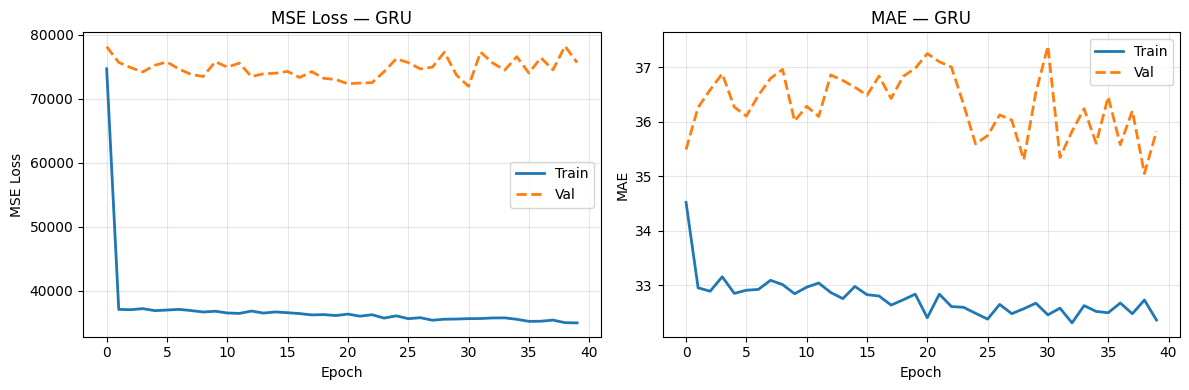

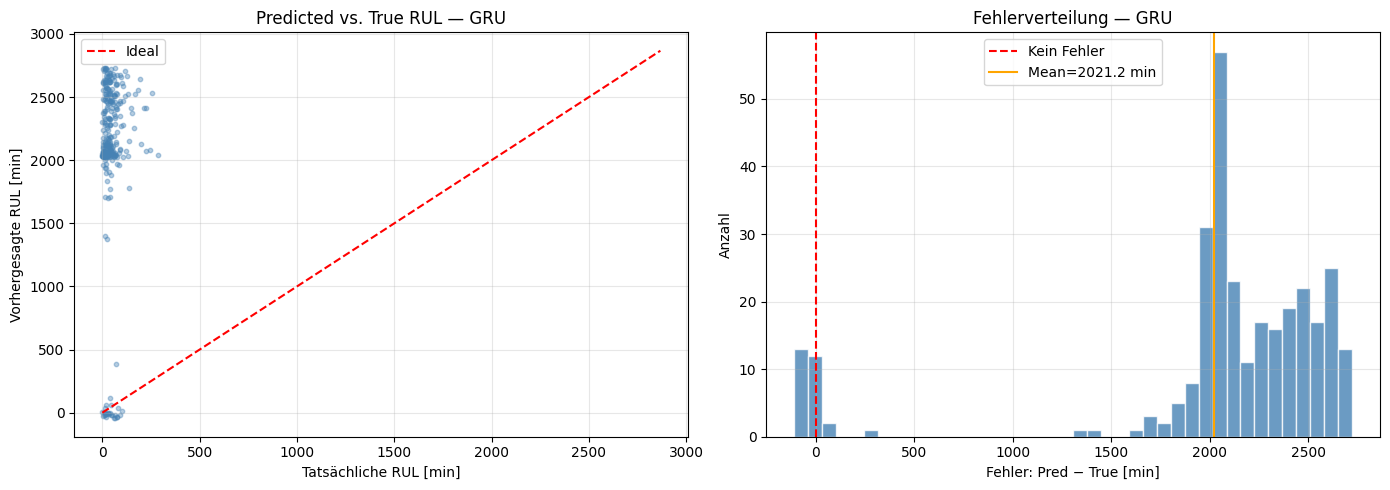

In [41]:
plot_training_history(history)
plot_predictions(results)

## Comparative Analysis

[Compare the performance of your model(s) against the baseline model. Discuss any improvements or setbacks and the reasons behind them.]


In [42]:
# Comparative Analysis code (if applicable)
# Example: comparing accuracy of the baseline model and the new model
# print(f"Baseline Model Accuracy: {baseline_accuracy}, New Model Accuracy: {new_model_accuracy}")


In [43]:
# Direkte Prediction auf skalierten Daten
y_pred_scaled = model.predict(X_test_scaled[:10])
print("Pred (skaliert):", y_pred_scaled.flatten())
print("True (skaliert):", y_test_scaled[:10].flatten())

# Rücktransformation
print("Pred (Minuten):", y_scaler.inverse_transform(y_pred_scaled).flatten())
print("True (Minuten):", y_scaler.inverse_transform(y_test_scaled[:10]).flatten())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Pred (skaliert): [50.709976  -1.6297374 49.40471   -1.1995678 58.35884   65.455185
 51.652374  49.61953   49.544098  50.842316 ]
True (skaliert): [-0.7855777   0.12817435 -0.62285477 -0.18475445 -0.93578357 -0.5853033
 -0.4476146   1.4549924   0.70396334 -0.04706578]
Pred (Minuten): [ 2.0714998e+03 -1.9220116e+01  2.0193605e+03 -2.0369101e+00
  2.3770352e+03  2.6605000e+03  2.1091440e+03  2.0279415e+03
  2.0249283e+03  2.0767859e+03]
True (Minuten): [ 14.500001  51.        20.999998  38.5        8.500001  22.5
  28.       104.        74.        44.      ]
